In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import time
from joblib import Parallel, delayed
import optuna
from optuna.pruners import BasePruner
from optuna.samplers import TPESampler
from scipy.spatial import distance

from SyncMap_Draft.core import SymmetricalSyncMap, LightSyncMap, NodeSyncMap
from SyncMap_Draft.utility import OverlapChunkTest1, to_categorical, compute_combi_dist, reduce_dimension_with_tsne, create_trace_plot, labels2colors
from SyncMap_Draft.processor import GraphProcessor, WorkingMemProcessor, Readout

np.set_printoptions(suppress=True, precision=4)
sns.set_theme()

In [5]:
# # initialize the environment
# time_delay = 10
# env = OverlapChunkTest1(time_delay)
# output_size = env.getOutputSize()
# output_size

# sequence_length = int(1000000) # True TEST
# # sequence_length = int(10000)  #  accuracy

# ####### SyncMap #####
# number_of_nodes= output_size
# adaptation_rate= 0.00005*output_size  # original
# # adaptation_rate= 0.0005*output_size
# print("Adaptation rate:", adaptation_rate)
# map_dimensions= 2
# neuron_group= NodeSyncMap(number_of_nodes, map_dimensions, adaptation_rate, max_track_length=2, use_tqdm=True)
# input_sequence, input_class = env.getSequence(sequence_length)


# neuron_group.fit(input_sequence>0.1)
# labels= neuron_group.cluster()

# print("Learned Labels: ",labels)
# print("Correct Labels: ",env.trueLabel())

Adaptation rate: 0.0004


In [8]:
# color_list = labels2colors(env.trueLabel())
# color_list, neuron_group.log.shape

# fig = create_trace_plot(neuron_group.log[::10000], colors = color_list)
# fig.show()

In [4]:
map_dimensions= 2
max_seq_length = 1000000
state_memory = 2
# experiment start
file_path = f'../data/probabilistic5_6.dot'
preprocessor = GraphProcessor()
preprocessor.read_graph_from_dot(file_path=file_path)
groundtruth_labels = preprocessor.get_groundtruth_labels()
connection_matrix = preprocessor.get_connection_matrix()
num_of_nodes = connection_matrix.shape[0]


# initialize sequence generator and set state_memory
seq_generator = WorkingMemProcessor(state_memory=state_memory)

# generate random walk on graph
input_seq_trajectory, input_seq_onehot = preprocessor.random_walk_on_graph(L=max_seq_length, reset_time=None)


Graph loaded from file: ../data/probabilistic5_6.dot
Number of nodes: 30
Number of edges: 170
Random walk starting node: 19


100%|██████████| 1000000/1000000 [00:09<00:00, 101263.09it/s]


In [23]:

neuron_group= NodeSyncMap(
    input_size = num_of_nodes, 
    dimensions = map_dimensions, 
    adaptation_rate = 0.0004, 
    max_track_length=4, use_tqdm=True,
    history_repel_factor=5000,
    minus_exp_factor = 2
    )


In [24]:
neuron_group.fit((input_seq_onehot[5:] + input_seq_onehot[4:-1] + input_seq_onehot[3:-2] + input_seq_onehot[2:-3] + input_seq_onehot[1:-4] + input_seq_onehot[:-5]))

  0%|          | 0/999995 [00:00<?, ?it/s]

100%|██████████| 999995/999995 [03:34<00:00, 4662.01it/s]


In [25]:
groundtruth_labels

array([1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 5, 5, 5, 5, 5, 5])

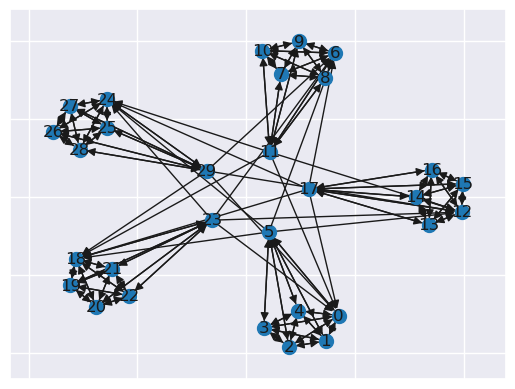

In [26]:
preprocessor.visualize_graph()

In [27]:
color_list = labels2colors(groundtruth_labels)

fig = create_trace_plot(neuron_group.log[::10000], colors = color_list)
fig.show()